In [6]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ijson
import googlemaps
import time
#please use pip to install the module: pip install -U googlemaps & pip install ijson



%matplotlib inline  
print (np.__version__)

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

1.13.3


In [7]:
os.chdir('D:\Teresa\Berkeley\Semester 3\W207 Applied Machine Learning\Final Project')
kiva_loans_data = pd.read_csv("kiva_loans.csv")
kiva_mpi_locations_data = pd.read_csv("kiva_mpi_region_locations.csv")
loan_theme_ids_data = pd.read_csv("loan_theme_ids.csv")
loan_themes_by_region_data = pd.read_csv("loan_themes_by_region.csv")
# Additional kiva snapshot data set
#loans_data = pd.read_csv("../input/additional-kiva-snapshot/loans.csv")
#lenders_data = pd.read_csv("../input/additional-kiva-snapshot/lenders.csv")
loans_lenders_data = pd.read_csv("loans_lenders.csv")
country_stats_data = pd.read_csv("country_stats.csv")
household_size = pd.read_csv("household_size.csv",sep=';')

#geconv4_data = pd.read_csv("../input/additional-kiva-snapshot/GEconV4.csv")
# Multidimensional Poverty Measures Data set
#mpi_national_data = pd.read_csv("../input/mpi/MPI_national.csv")
mpi_subnational_data = pd.read_csv("MPI_subnational.csv")
kiva_dhs_v4 = pd.read_csv("KIVA.DHSv4.csv")
dhs_clusters = pd.read_csv("DHS.clusters.csv")
indicators = pd.read_csv("indicators.csv",sep=';', encoding = "ISO-8859-1",decimal=',')

In [8]:
print("Size")
print("kiva_loans_data:", kiva_loans_data.shape)
print("kiva_mpi_locations_data:", kiva_mpi_locations_data.shape)
print("loan_theme_ids_data:",loan_theme_ids_data.shape)
print("loan_themes_by_region_data:", loan_themes_by_region_data.shape)
print("loans_lenders_data:", loans_lenders_data.shape)
print("country_stats_data:", country_stats_data.shape)
print("household_size:", household_size.shape)
print("mpi_subnational_data:", mpi_subnational_data.shape )
print("kiva_dhs_v4", kiva_dhs_v4.shape)
print("dhs_clusters:", dhs_clusters.shape)
print("indicators:", indicators.shape)

Size
kiva_loans_data: (671205, 20)
kiva_mpi_locations_data: (2772, 9)
loan_theme_ids_data: (779092, 4)
loan_themes_by_region_data: (15736, 21)
loans_lenders_data: (1387432, 2)
country_stats_data: (174, 13)
household_size: (37, 4)
mpi_subnational_data: (984, 8)
kiva_dhs_v4 (5266, 123)
dhs_clusters: (6778, 101)
indicators: (264, 9)


### Kiva Loans Data

In [11]:
kiva_loans_data.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count
count,6.712050e+05,671205.000000,671205.000000,657698.000000,671205.000000,671205.000000
mean,9.932486e+05,785.995061,842.397107,178.199616,13.739022,20.590922
std,1.966113e+05,1130.398941,1198.660073,94.247581,8.598919,28.459551
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,0.000000
25%,8.230720e+05,250.000000,275.000000,126.000000,8.000000,7.000000
50%,9.927800e+05,450.000000,500.000000,145.000000,13.000000,13.000000
75%,1.163653e+06,900.000000,1000.000000,204.000000,14.000000,24.000000
max,1.340339e+06,100000.000000,100000.000000,536.000000,158.000000,2986.000000


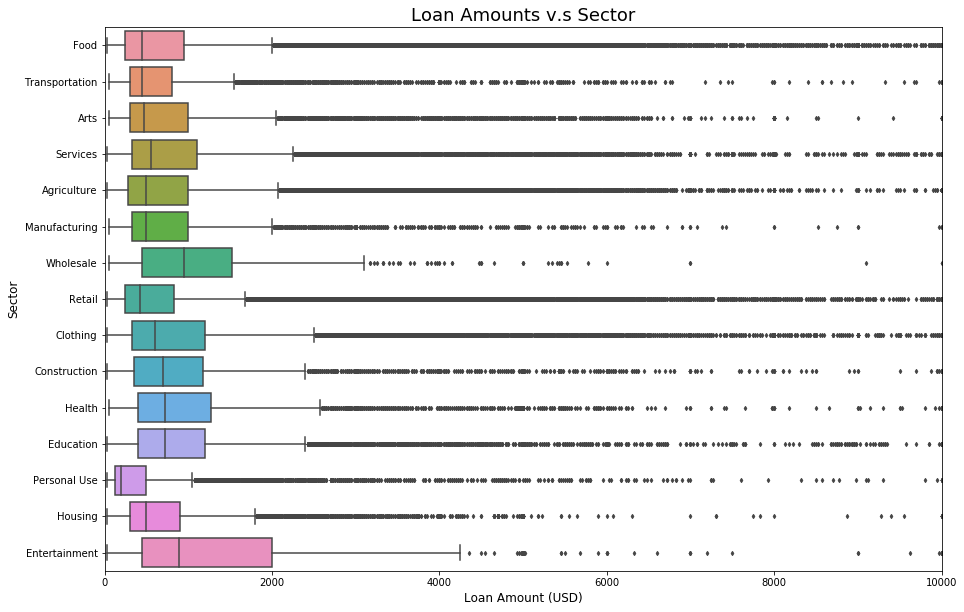

In [10]:
#Does loan amount change with sector?
plt.figure(figsize = (15, 10))
sns.boxplot(x = 'loan_amount', y = 'sector', data = kiva_loans_data, fliersize = 3);
plt.xlim(0, 10000)
plt.xlabel("Loan Amount (USD)", fontsize = 12)
plt.ylabel("Sector", fontsize = 12)
plt.title("Loan Amounts v.s Sector", fontsize = 18);

Loan amounts is slightly different by sector. The sector with the lowest median and variation is under personal use, and the sector with the highest median and variation falls under entertainment. We set the maximim amount as $10,000 for better readibility but the actual maximum loan amount is 100,000.

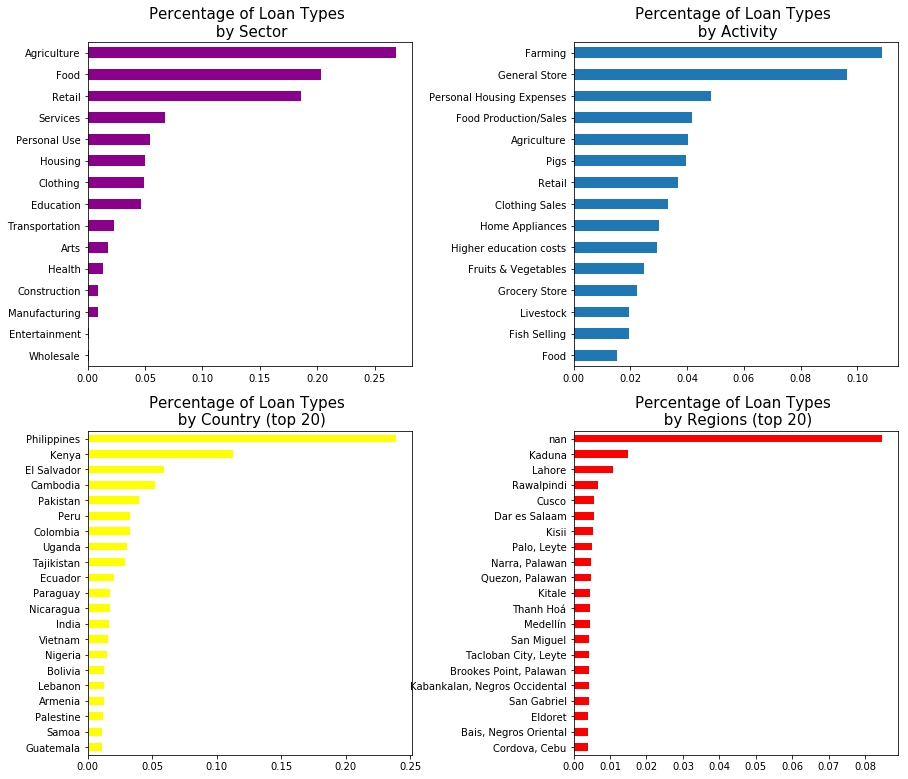

In [16]:
fig = plt.figure(figsize=(9,9))

#Distribution of Loans by Sector (Description of loan activity as shown to lenders)
axis1 = fig.add_axes([0,.6,.5,.5])
axis1 = kiva_loans_data['sector'].value_counts(normalize = True).sort_values(ascending = True).plot(kind = 'barh', color = 'darkmagenta')
axis1.set_title("Percentage of Loan Types \n by Sector", fontsize = 15);

#Distribution of Loans Activity Type 
axis2 = fig.add_axes([0.75,.6,.5,.5])
axis2 = kiva_loans_data['activity'].value_counts(normalize = True).sort_values(ascending = True)[-15:].plot(kind = 'barh')
axis2.set_title("Percentage of Loan Types \n by Activity", fontsize = 15);

#Distribution of Loans by Countries
axis3 = fig.add_axes([0,0,.5,.5])
axis3 = kiva_loans_data['country'].value_counts(normalize = True).sort_values(ascending = True)[-21:].plot(kind = 'barh', color = 'yellow')
axis3.set_title("Percentage of Loan Types \n by Country (top 20)", fontsize = 15);

#Distribution of Loans by Regions
axis4 = fig.add_axes([0.75,0,.5,.5])
axis4 = kiva_loans_data['region'].value_counts(normalize = True,dropna = False).sort_values(ascending = True)[-21:].plot(kind = 'barh', color = 'red')
axis4.set_title("Percentage of Loan Types \n by Regions (top 20)", fontsize = 15);

Three most popular sectors include: Agriculture, Food and Retail--making up almost 65% of all loans.
Two most popular activities: Farming and General Store -- representing about 20% of the data 
The most popular country: Philippines
The region is 85% missing in this dataset

D:\Python\lib\site-packages\matplotlib\__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


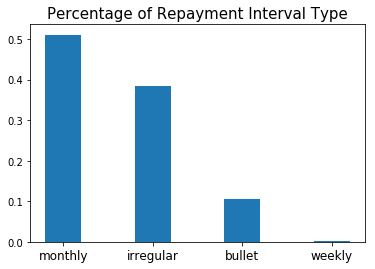

In [20]:
#Plot repayment interval
plt.bar(left = np.arange(len(kiva_loans_data['repayment_interval'].value_counts(normalize = True))), \
        height = kiva_loans_data['repayment_interval'].value_counts(normalize = True), width = 0.4)
plt.xticks(np.arange(4), list(kiva_loans_data['repayment_interval'].value_counts(normalize = True).keys()), fontsize = 12)
plt.title("Percentage of Repayment Interval Type", fontsize = 15);

### Kiva MPI and Locations

In [24]:
kiva_mpi_locations_data.isnull().sum()
#Drop all rows with missing values
kiva_mpi_locations_data = kiva_mpi_locations_data.dropna()

In [25]:
kiva_mpi_locations_data[['MPI']].describe()

,MPI
count,892.00000
mean,0.21066
std,0.18210
min,0.00000
25%,0.05400
50%,0.15550
75%,0.33850
max,0.74400


In [27]:
#Top 20 MPI countries
kiva_mpi_locations_data.groupby('country')[['MPI']].mean().sort_values(by = 'MPI',ascending = False)[:21]

,MPI
country,
Chad,0.587059
Burkina Faso,0.544917
Niger,0.543375
South Sudan,0.540000
Ethiopia,0.492273
Sierra Leone,0.481071
Guinea,0.471600
Central African Republic,0.444750
Guinea-Bissau,0.438375


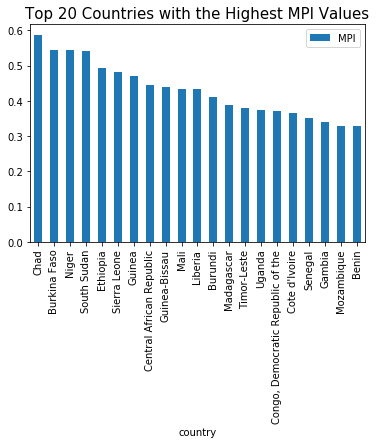

In [29]:
plt.figure(figsize = (10,4))
kiva_mpi_locations_data.groupby('country')[['MPI']].mean().sort_values(by = 'MPI',ascending = False)[:21].plot(kind = 'bar')
plt.title("Top 20 Countries with the Highest MPI Values", fontsize = 15);

### Kiva Loan Theme IDs

In [31]:
loan_theme_ids_data.columns

Index(['id', 'Loan Theme ID', 'Loan Theme Type', 'Partner ID'], dtype='object')

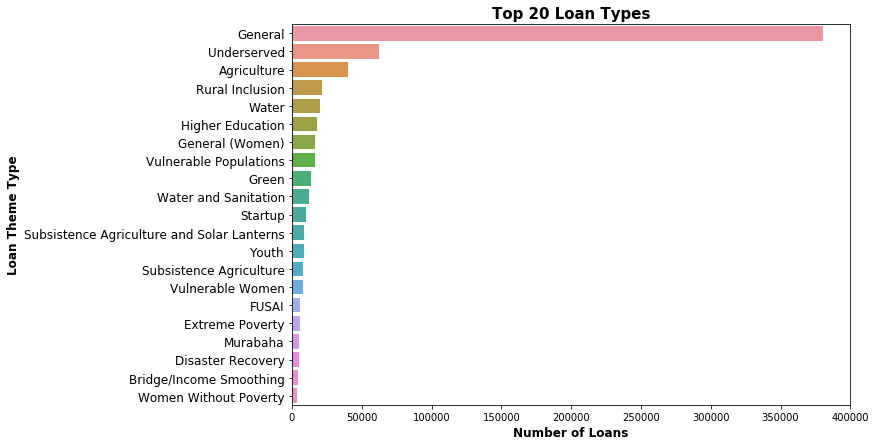

In [32]:
#Distribution of loan theme type
theme_count = loan_theme_ids_data.groupby('Loan Theme Type')[['Loan Theme Type']].count().rename(columns= {'Loan Theme Type':'count'}).reset_index().sort_values(by = 'count', ascending = False)

plt.figure(figsize = (10,7))
sns.barplot(x = 'count', y = 'Loan Theme Type', data = theme_count[0:21])
plt.yticks(fontsize = 12)
plt.ylabel("Loan Theme Type", fontsize = 12, weight = 'bold')
plt.xlabel("Number of Loans", fontsize = 12, weight = 'bold')
plt.title("Top 20 Loan Types", fontsize = 15, weight = 'bold');